In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
from scipy.spatial import ConvexHull
from scipy.ndimage import gaussian_filter1d
import pandas as pd
from matplotlib.colors import Normalize
from matplotlib import cm
from rd_solver import *
from itertools import combinations, product
import importlib
import warnings
warnings.filterwarnings("ignore")

from shared import *

In [2]:
import simulation_loader
importlib.reload(simulation_loader)
simulations = simulation_loader.Simulations(
    result_path="/run/media/cdmium/9A986168986143BB/proofreading/result_20250225",
    parameter_path="parameters_20250225",
)
betas = ["baseline"]
for b in simulations.get_keys():
    if b != betas[0]:
        betas.append(b)

Parameters loaded.
{('parameters', None): (40000, 4)}
reading baseline
Simulations result loaded.
{'baseline': (40000, 7)}


In [3]:
xlim = [-1, 10]
ylim = [-5, 2]
aspect_ratio = 1
branch_name = "intracellular"

In [4]:
# Desired plot area size for each subplot (in inches)
PLOT_WIDTH = 2.5
PLOT_HEIGHT = 2.5
LEFT_MARGIN = 0.8   # Space for y-tick labels
BOTTOM_MARGIN = 0.6  # Space for x-tick labels
TITLE_SPACE = 0.4   # Space for subplot title
RIGHT_MARGIN = 0.2  # Right buffer
TOP_BUFFER = 0.4

def format_10n(x, pos):
    return f"$10^{{{int(x)}}}$"


def format_subplots(fig, axes, plot_width=PLOT_WIDTH, plot_height=PLOT_HEIGHT):
    """
    Adjust subplots from plt.subplots() to have a fixed plot area size with reserved space.
    Args:
        fig: Matplotlib Figure object
        axes: Array of Axes objects (or single Axes)
        plot_width: Width of each subplot's plot area (inches)
        plot_height: Height of each subplot's plot area (inches)
    """
    # Normalize axes to 2D array
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])
    if axes.ndim == 1:
        axes = axes.reshape(-1, 1)
    n_rows, n_cols = axes.shape

    # Calculate total figure size based on fixed dimensions
    total_plot_width = n_cols * plot_width
    total_plot_height = n_rows * (plot_height + TITLE_SPACE)  # Add title space per row
    fig_width = LEFT_MARGIN + total_plot_width + RIGHT_MARGIN
    fig_height = BOTTOM_MARGIN + total_plot_height + TOP_BUFFER

    # Resize figure
    fig.set_size_inches(fig_width, fig_height)

    # Reposition each subplot
    for i in range(n_rows):
        for j in range(n_cols):
            ax = axes[i, j]
            # Position in figure coordinates (0-1)
            left = (LEFT_MARGIN + j * plot_width) / fig_width
            # Bottom starts from top, accounting for title space
            bottom = (TOP_BUFFER + (n_rows - 1 - i) * (plot_height + TITLE_SPACE) + TITLE_SPACE) / fig_height
            width = plot_width / fig_width
            height = plot_height / fig_height
            ax.set_position([left, bottom, width, height])

            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.spines['left'].set_color('k')
            ax.spines['left'].set_linewidth(1.0)
            ax.spines['bottom'].set_color('k')
            ax.spines['bottom'].set_linewidth(1.0)
            ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_10n))
            ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_10n))

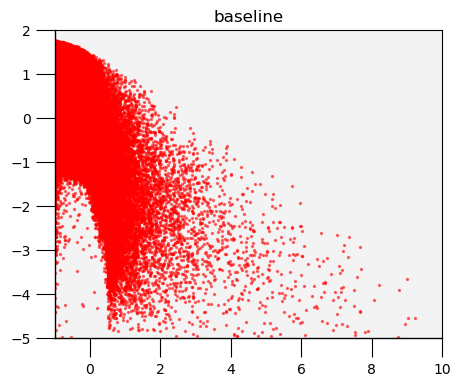

In [5]:
# basic scatter plot
fig, axs = plt.subplots(len(betas), 1, figsize=(5, len(betas) * 4))
axs = np.array([axs])

for i, beta in enumerate(betas):
    axs[i].scatter(
        simulations.get_fidelity_log(beta),
        simulations.get_AC_log(beta),
        2, color='red', alpha=0.5
    )
    axs[i].title.set_text(beta)
for ax in axs.flatten():
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # ax.plot([0, 25], [1.5, -11])

    ax.set_facecolor('#F3F3F3')
    ax.spines['left'].set_color('k')
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['bottom'].set_color('k')
    ax.spines['bottom'].set_linewidth(1.0)

    ax.tick_params(axis="y", labelleft=True, size=14)
    ax.tick_params(axis="x", labelbottom=True, size=14)
    ax.tick_params(axis="y", labelleft=True, size=14)
    ax.tick_params(axis="x", labelbottom=True, size=14)

# plt.savefig("simple_scatter.svg")
plt.show()

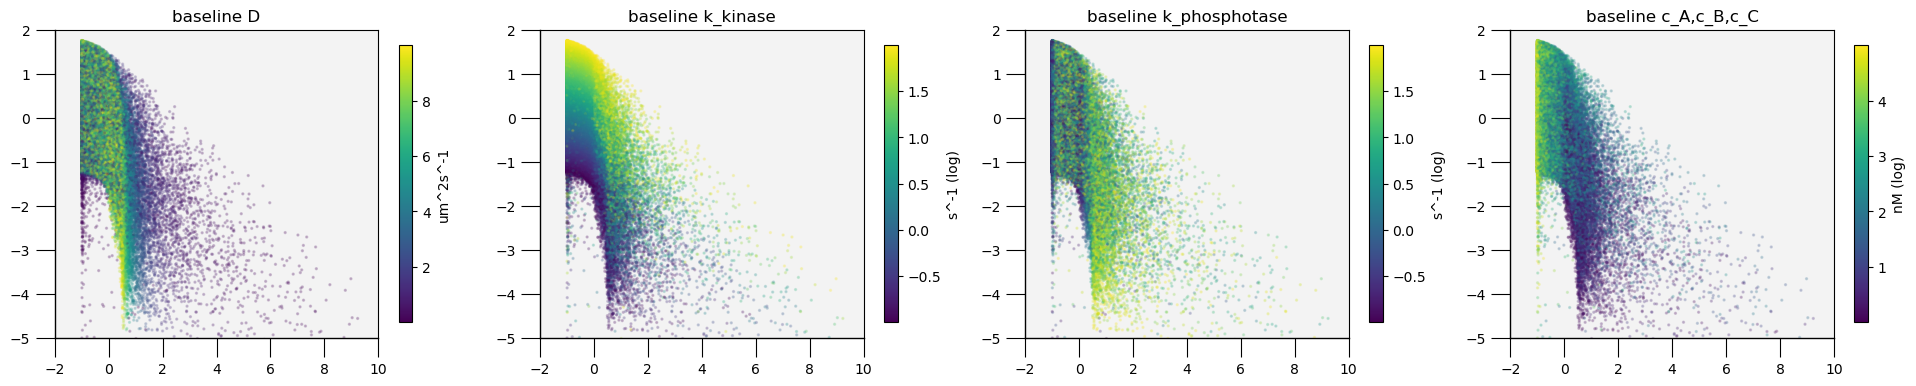

In [55]:
# basic scatter plot
fig, axs = plt.subplots(
    len(betas), num_dimensions, figsize=(
        6 * num_dimensions, len(betas) * 4))
axs = np.array([axs])
parameter_name = ["D", "k_kinase", "k_phosphotase", "c_A,c_B,c_C"]
parameter_unit = ["um^2s^-1", "s^-1 (log)", "s^-1 (log)", "nM (log)"]

for i, beta in enumerate(betas):
    for j in range(0, num_dimensions):
        p = axs[i, j].scatter(
            simulations.get_fidelity_log(beta),
            simulations.get_AC_log(beta),
            2, c=simulations.get_parameters_log()[:, j], alpha=0.2
        )
        axs[i, j].title.set_text("{} {}".format(beta, parameter_name[j]))

        # recreate color bar for solid color
        parameters_log = simulations.get_parameters_log()[:, j]
        norm = matplotlib.colors.Normalize(
            vmin=parameters_log.min(),
            vmax=parameters_log.max()
        )
        cbar = fig.colorbar(
            matplotlib.cm.ScalarMappable(norm=norm, cmap="viridis"),
            shrink=0.9, ax=axs[i, j],
            label=parameter_unit[j]
        )
for ax in axs.flatten():
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # ax.plot([0, 25], [1.5, -11])

    ax.set_facecolor('#F3F3F3')
    ax.spines['left'].set_color('k')
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['bottom'].set_color('k')
    ax.spines['bottom'].set_linewidth(1.0)

    ax.tick_params(axis="y", labelleft=True, size=14)
    ax.tick_params(axis="x", labelbottom=True, size=14)
    ax.tick_params(axis="y", labelleft=True, size=14)
    ax.tick_params(axis="x", labelbottom=True, size=14)

# plt.savefig("simple_scatter.svg")
plt.show()

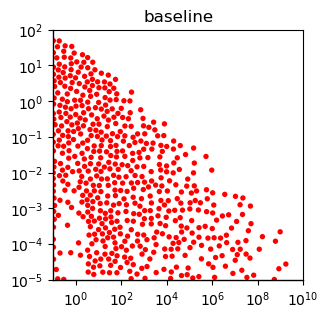

In [6]:
import matplotlib.ticker as ticker

# add subset of proofreading and enough concentration
for b in betas:
    simulations.add_subset(
        ("proofreading", b),
        np.bitwise_and(
            simulations.get_fidelity_log(b) > 0,
            simulations.get_subset(subsets=[("valid", b)])
        )
    )
for b in betas:
    simulations.add_subset(
        ("active", b),
        np.bitwise_and(
            simulations.get_AC_log(b) > -1,
            simulations.get_subset(subsets=[("valid", b)])
        )
    )

# simplified scatter
distance_threshold = 0.022

# create subset for simplified data
for b in betas:
    subset = []
    f_simple = np.array([])
    ac_simple = np.array([])
    for f, ac in zip(
        simulations.get_fidelity_log(b), simulations.get_AC_log(b)
    ):
        if f < xlim[0] or f > xlim[1] or ac < ylim[0] or ac > ylim[1]:
            subset.append(False)
        elif np.all(
            np.linalg.norm(
                np.array(
                    [
                        (f_simple - f) / (xlim[1] - xlim[0]),
                        (ac_simple - ac) / (ylim[1] - ylim[0]) * aspect_ratio
                    ]
                ),
                axis=0
            ) > distance_threshold
        ):
            f_simple = np.append(f_simple, f)
            ac_simple = np.append(ac_simple, ac)
            subset.append(True)
        else:
            subset.append(False)
    subset = np.array(subset)
    # increase point number for group with too small point set
    if b != "baseline" and len(f_simple) < np.count_nonzero(
        simulations.get_subset(subsets=[("simplified", "baseline")])
    ):
        false_indices = np.where(subset == False)[0]
        indices_to_change = np.random.choice(
            false_indices,
            size=np.count_nonzero(
                simulations.get_subset(subsets=[("simplified", "baseline")])
            ) - len(f_simple),
            replace=False
        )
        subset[indices_to_change] = True

    simulations.add_subset(
        ("simplified", b),
        subset
    )


fig, axs = plt.subplots(len(betas), 1, figsize=(5, len(betas) * 4))
axs = np.array([axs])

for i, b in enumerate(betas):
    axs[i].scatter(
        simulations.get_fidelity_log(
            beta=b, subsets=["simplified"]
        ),
        simulations.get_AC_log(
            beta=b, subsets=["simplified"]
        ),
        15,
        color='red',
        alpha=1,
        edgecolor="none",
    )
    axs[i].title.set_text(b)

format_subplots(fig, axs)

plt.savefig(branch_name + "simplified_scatter.svg")
plt.show()
#  TODO highlight

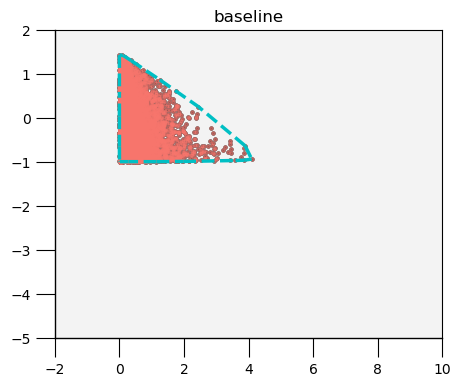

In [66]:

ggcolors = {
    1: ["#F8766D"],
    2: ["#F8766D", "#00BFC4"],
    3: ["#F8766D", "#00BA38", "#619CFF"],
    4: ["#F8766D", "#7CAE00", "#00BFC4", "#C77CFF"],
    5: ["#F8766D", "#A3A500", "#00BF7D", "#00B0F6", "#E76BF3"],
    6: ["#F8766D", "#B79F00", "#00BA38", "#00BFC4", "#619CFF", "#F564E3"],
    7: ["#F8766D", "#C49A00", "#53B400", "#00C094", "#00B6EB", "#A58AFF", "#FB61D7"],
    8: ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"],
}


# * analyze shifted points

# hull_data_fidelity_AC_log = np.array(
#     [heatmap_data_fidelity_log, heatmap_data_AC_log]
# ).T
# hull_data_fidelity_AC_log_feedback = np.array(
#     [heatmap_data_fidelity_log_feedback, heatmap_data_AC_log_feedback]
# ).T

# create convex hull object
hull = ConvexHull(
    np.array([
        simulations.get_fidelity_log(beta="baseline", subsets=["proofreading", "active", "valid"]),
        simulations.get_AC_log(beta="baseline", subsets=["proofreading", "active", "valid"]),
    ]).T
)


def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull, Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p) >= 0


# calcualte which points (with feedback) is inside convex hull (without
# feedback) or not
for b in betas:
    simulations.add_subset(
        ("in_hull", b),
        in_hull(
            np.array([
                simulations.get_fidelity_log(beta=b),
                simulations.get_AC_log(beta=b)
            ]).T,
            hull.points
        )
    )


# plot
fig, axs = plt.subplots(len(betas), 1, figsize=(5, (len(betas) - 0) * 4))
axs = np.array([axs])
for i, b in enumerate(betas):
    # scatter for beta==0 (no feedback)
    axs[i].scatter(
        simulations.get_fidelity_log(beta="baseline", subsets=["in_hull"]),
        simulations.get_AC_log(beta="baseline", subsets=["in_hull"]),
        5,
        color=[0.25, 0.25, 0.25],
        alpha=1
    )
    # draw convex hull
    for simplex in hull.simplices:
        axs[i].plot(
            simulations.get_fidelity_log(
                beta="baseline", subsets=["proofreading", "active"]
            )[simplex],
            simulations.get_AC_log(
                beta="baseline", subsets=["proofreading", "active"]
            )[simplex],
            "--",
            color=ggcolors[2][1],
            lw=2.5,
        )
    # scatter for inside hull
    axs[i].scatter(
        simulations.get_fidelity_log(beta=b, subsets=["in_hull"]),
        simulations.get_AC_log(beta=b, subsets=["in_hull"]),
        5,
        color=ggcolors[2][0],
        alpha=0.5,
    )
    # scatter for outside hull
    axs[i].scatter(
        simulations.get_fidelity_log(
            beta=b, subsets=["proofreading", "active"], not_subsets=["in_hull"]
        ),
        simulations.get_AC_log(
            beta=b, subsets=["proofreading", "active"], not_subsets=["in_hull"]
        ),
        5,
        color="red",
        alpha=0.5,
    )
    axs[i].title.set_text(b)

for ax in axs.flatten():
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # ax.plot([0, 25], [1.5, -11])

    ax.set_facecolor('#F3F3F3')
    ax.spines['left'].set_color('k')
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['bottom'].set_color('k')
    ax.spines['bottom'].set_linewidth(1.0)

    ax.tick_params(axis="y", labelleft=True, size=14)
    ax.tick_params(axis="x", labelbottom=True, size=14)
    ax.tick_params(axis="y", labelleft=True, size=14)
    ax.tick_params(axis="x", labelbottom=True, size=14)

plt.savefig("convex_hall.svg", dpi=150)
plt.show()


In [80]:
for b in betas:
    print(
        "beta: {}, inside triangle: {}, outside trignale: {}, total: {}"
        .format(
            b,
            len(
                simulations.get_AC(
                    beta=b,
                    subsets=["valid", "proofreading", "active", "in_hull"]
                )
            ),
            len(
                simulations.get_AC(
                    beta=b,
                    subsets=["valid", "proofreading", "active"],
                    not_subsets=["in_hull"]
                )
            ),
            len(
                simulations.get_AC(
                    beta=b, subsets=["valid", "proofreading", "active"]
                )
            )
        )
    )

beta: baseline, inside triangle: 2125, outside trignale: 0, total: 2125
beta: b_ac1_k_ac3, inside triangle: 2408, outside trignale: 2694, total: 5102
beta: b_ac0.5, inside triangle: 2641, outside trignale: 2001, total: 4642
beta: b_ac1_k_ac6, inside triangle: 2262, outside trignale: 2358, total: 4620
beta: b_ac1, inside triangle: 2416, outside trignale: 2955, total: 5371
beta: b_ac1_n_ac6, inside triangle: 1001, outside trignale: 4142, total: 5143
beta: b_ac1_n_ac3, inside triangle: 1250, outside trignale: 4100, total: 5350
beta: b_ac_rp1, inside triangle: 2240, outside trignale: 14561, total: 16801
beta: b_rp1, inside triangle: 119, outside trignale: 6162, total: 6281
beta: b_ac2, inside triangle: 1120, outside trignale: 4000, total: 5120
beta: sender_ratio3, inside triangle: 2151, outside trignale: 12, total: 2163
beta: sender_region451, inside triangle: 0, outside trignale: 0, total: 0


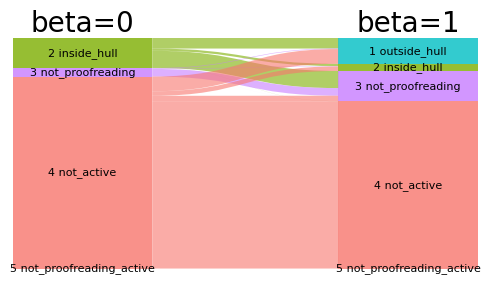

In [15]:
import sys

import sankey_mod
sys.path.append("./")



importlib.reload(sankey_mod)


sankey_raw = []


# Combine into a single array
group_names = [
    "1 outside_hull",
    "2 inside_hull",
    "3 not_proofreading",
    "4 not_active",
    "5 not_proofreading_active",
    "6 invalid",
]


def map_group_name(v):
    for name, boolean in zip(group_names, v):
        if boolean:
            return name

_betas = [0, 1]
for b in _betas:
    is_invalid = simulations.get_subset(
        subsets=None, not_subsets=[("valid", b)]
    )
    is_not_proofreading = simulations.get_subset(
        subsets=[("active", b)], not_subsets=[("proofreading", b)]
    )
    is_not_active = simulations.get_subset(
        subsets=[("proofreading", b)], not_subsets=[("active", b)]
    )
    is_not_proofreading_active = simulations.get_subset(
        subsets=[("valid", b)],
        not_subsets=[("proofreading", b), ("active", b)]
    )
    is_in_hull = simulations.get_subset(subsets=[("in_hull", b)])
    is_outside_hull = simulations.get_subset(
        subsets=[("proofreading", b), ("active", b)],
        not_subsets=[("in_hull", b)]
    )

    booleans = np.array([
        is_outside_hull,
        is_in_hull,
        is_not_proofreading,
        is_not_active,
        is_not_proofreading_active,
        is_invalid,
    ])

    sankey_raw.append(
        list(map(map_group_name, booleans.T))
    )

sankey_raw = np.array(sankey_raw)

sankey_table = {}

for sim in sankey_raw.T:
    if None in sim or "6 invalid" in sim:
        continue
    if tuple(sim) not in sankey_table:
        sankey_table[tuple(sim)] = 1
    else:
        sankey_table[tuple(sim)] += 1

# remove all zero-weight
keys = list(sankey_table.keys())
for i, k in enumerate(keys):
    if sankey_table[k] == 0:
        sankey_table.pop(k)



plt.figure(figsize=(6, 3))
sankey_mod.sankey(
    pd.DataFrame(
        [[sankey_table[k]] + list(k) for k in sankey_table],
        columns=["Weight"] + ["beta={}".format(b) for b in _betas],
    ),
    # since we have only one not proofreading & not active, just assign white for it
    nodes_color=ggcolors[4] + ["#FFFFFF"],
    labels_size=8,
    sort_flows_by_nodes=True
)
plt.savefig("sankey_full.svg")
plt.show()

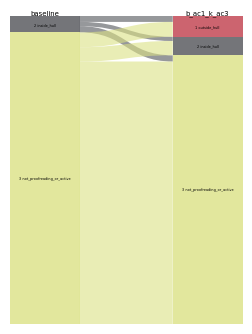

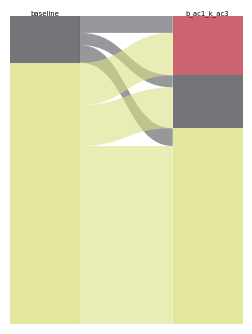

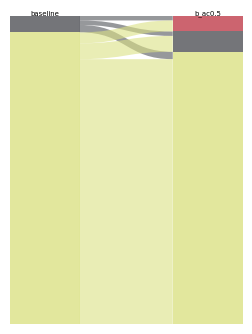

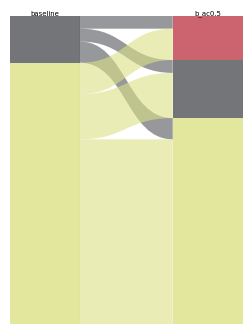

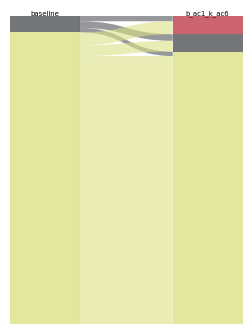

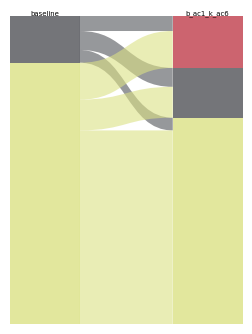

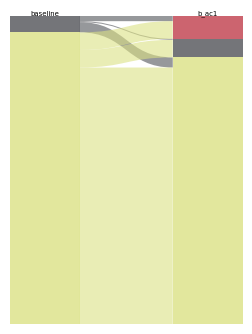

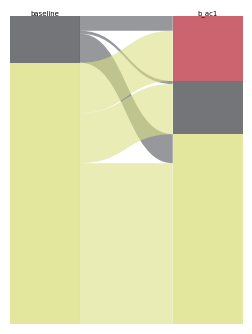

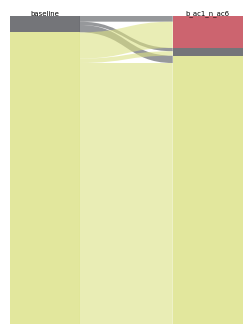

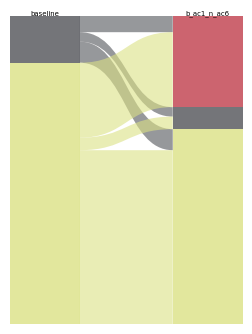

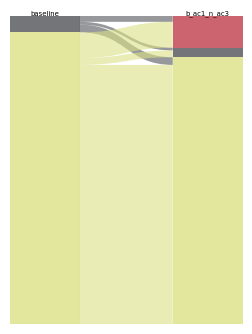

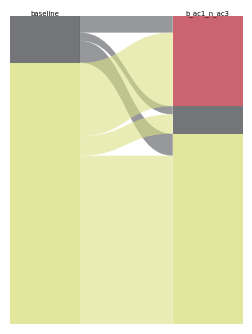

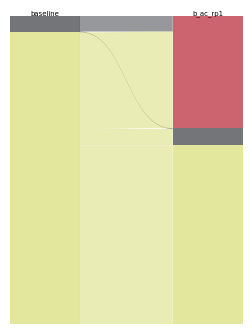

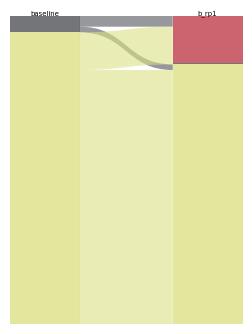

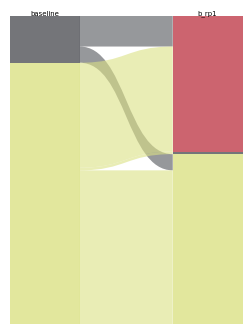

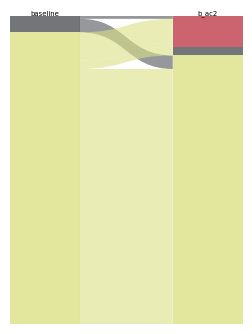

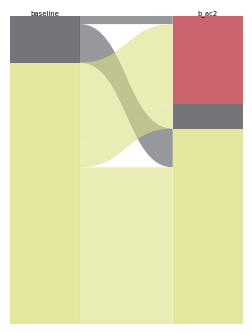

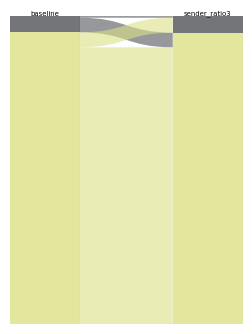

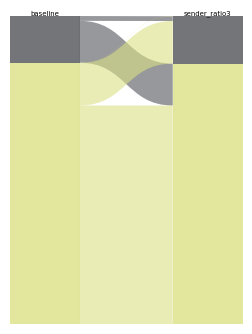

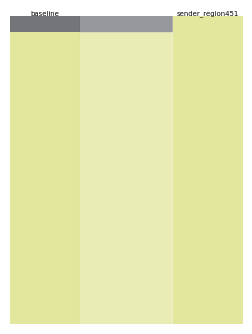

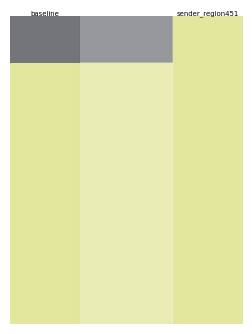

In [81]:
import importlib
import sys

import sankey_mod
sys.path.append("./")


importlib.reload(sankey_mod)


sankey_raw = []


# Combine into a single array
group_names = [
    "1 outside_hull",
    "2 inside_hull",
    "3 not_proofreading_or_active",
    "4 invalid",
]


def map_group_name(v):
    for name, boolean in zip(group_names, v):
        if boolean:
            return name


for b in betas:
    is_invalid = simulations.get_subset(
        subsets=None, not_subsets=[("valid", b)]
    )
    is_not_proofreading = simulations.get_subset(
        subsets=[("valid", b)],
        not_subsets=[("proofreading", b)]
    )
    is_not_active = simulations.get_subset(
        subsets=[("valid", b)],
        not_subsets=[("active", b)]
    )
    is_in_hull = simulations.get_subset(subsets=[("in_hull", b)])
    is_outside_hull = simulations.get_subset(
        subsets=[("proofreading", b), ("active", b)],
        not_subsets=[("in_hull", b)]
    )

    booleans = np.array([
        is_outside_hull,
        is_in_hull,
        np.bitwise_or(is_not_proofreading, is_not_active),
        is_invalid,
    ])

    sankey_raw.append(
        list(map(map_group_name, booleans.T))
    )

sankey_raw = np.array(sankey_raw)

zoomin_size = 14000
b0 = betas[0]
for i, b1 in enumerate(betas[1:]):
    # b1 = beta_dict[b1]
    sankey_raw_subset = sankey_raw[[0, i + 1], :]
    sankey_table = {}

    for sim in sankey_raw_subset.T:
        if None in sim or "4 invalid" in sim:
            continue
        if tuple(sim) not in sankey_table:
            sankey_table[tuple(sim)] = 1
        else:
            sankey_table[tuple(sim)] += 1

    # remove all zero-weight
    keys = list(sankey_table.keys())
    for k in keys:
        if sankey_table[k] == 0:
            sankey_table.pop(k)

    # remove color of outside .. if having no that value
    sankey_colors = ["#515358", "#dbe185"]
    keys = list(sankey_table)
    for k in keys:
        if k[1] == "1 outside_hull":
            sankey_colors = ["#515358", "#c03d4b", "#dbe185"]
            break

    plt.figure(figsize=(3, 4))
    sankey_mod.sankey(
        pd.DataFrame(
            [[sankey_table[k]] + list(k) for k in sorted(sankey_table)],
            columns=["Weight"] + [b0, b1],
        ),
        nodes_color=sankey_colors,
        sort_flows_by_nodes=True,
        labels_size=2.5,
        titles_size=5,
        labels_color="black" if i == 0 else None,
    )
    plt.savefig("sankey_merged_{} to {}.svg".format(b0, b1))
    plt.show()

    sim_count = 0
    for k in sankey_table:
        if k != ('3 not_proofreading_or_active', '3 not_proofreading_or_active'):
            sim_count += sankey_table[k]

    # skip zoom if got minus weight
    if zoomin_size < sim_count:
        continue
    sankey_table[
        ('3 not_proofreading_or_active', '3 not_proofreading_or_active')
    ] = zoomin_size - sim_count

    plt.figure(figsize=(3, 4))
    sankey_mod.sankey(
        pd.DataFrame(
            [[sankey_table[k]] + list(k) for k in sorted(sankey_table)],
            columns=["Weight"] + [b0, b1],
        ),
        nodes_color=sankey_colors,
        sort_flows_by_nodes=True,
        labels_size=2.5,
        titles_size=5,
        # labels_color="black" if i == 0 else None,
        labels_color=None if i == 0 else None,
    )

    plt.savefig("sankey_merged_zoom_{} to {}.svg".format(b0, b1))
    plt.show()

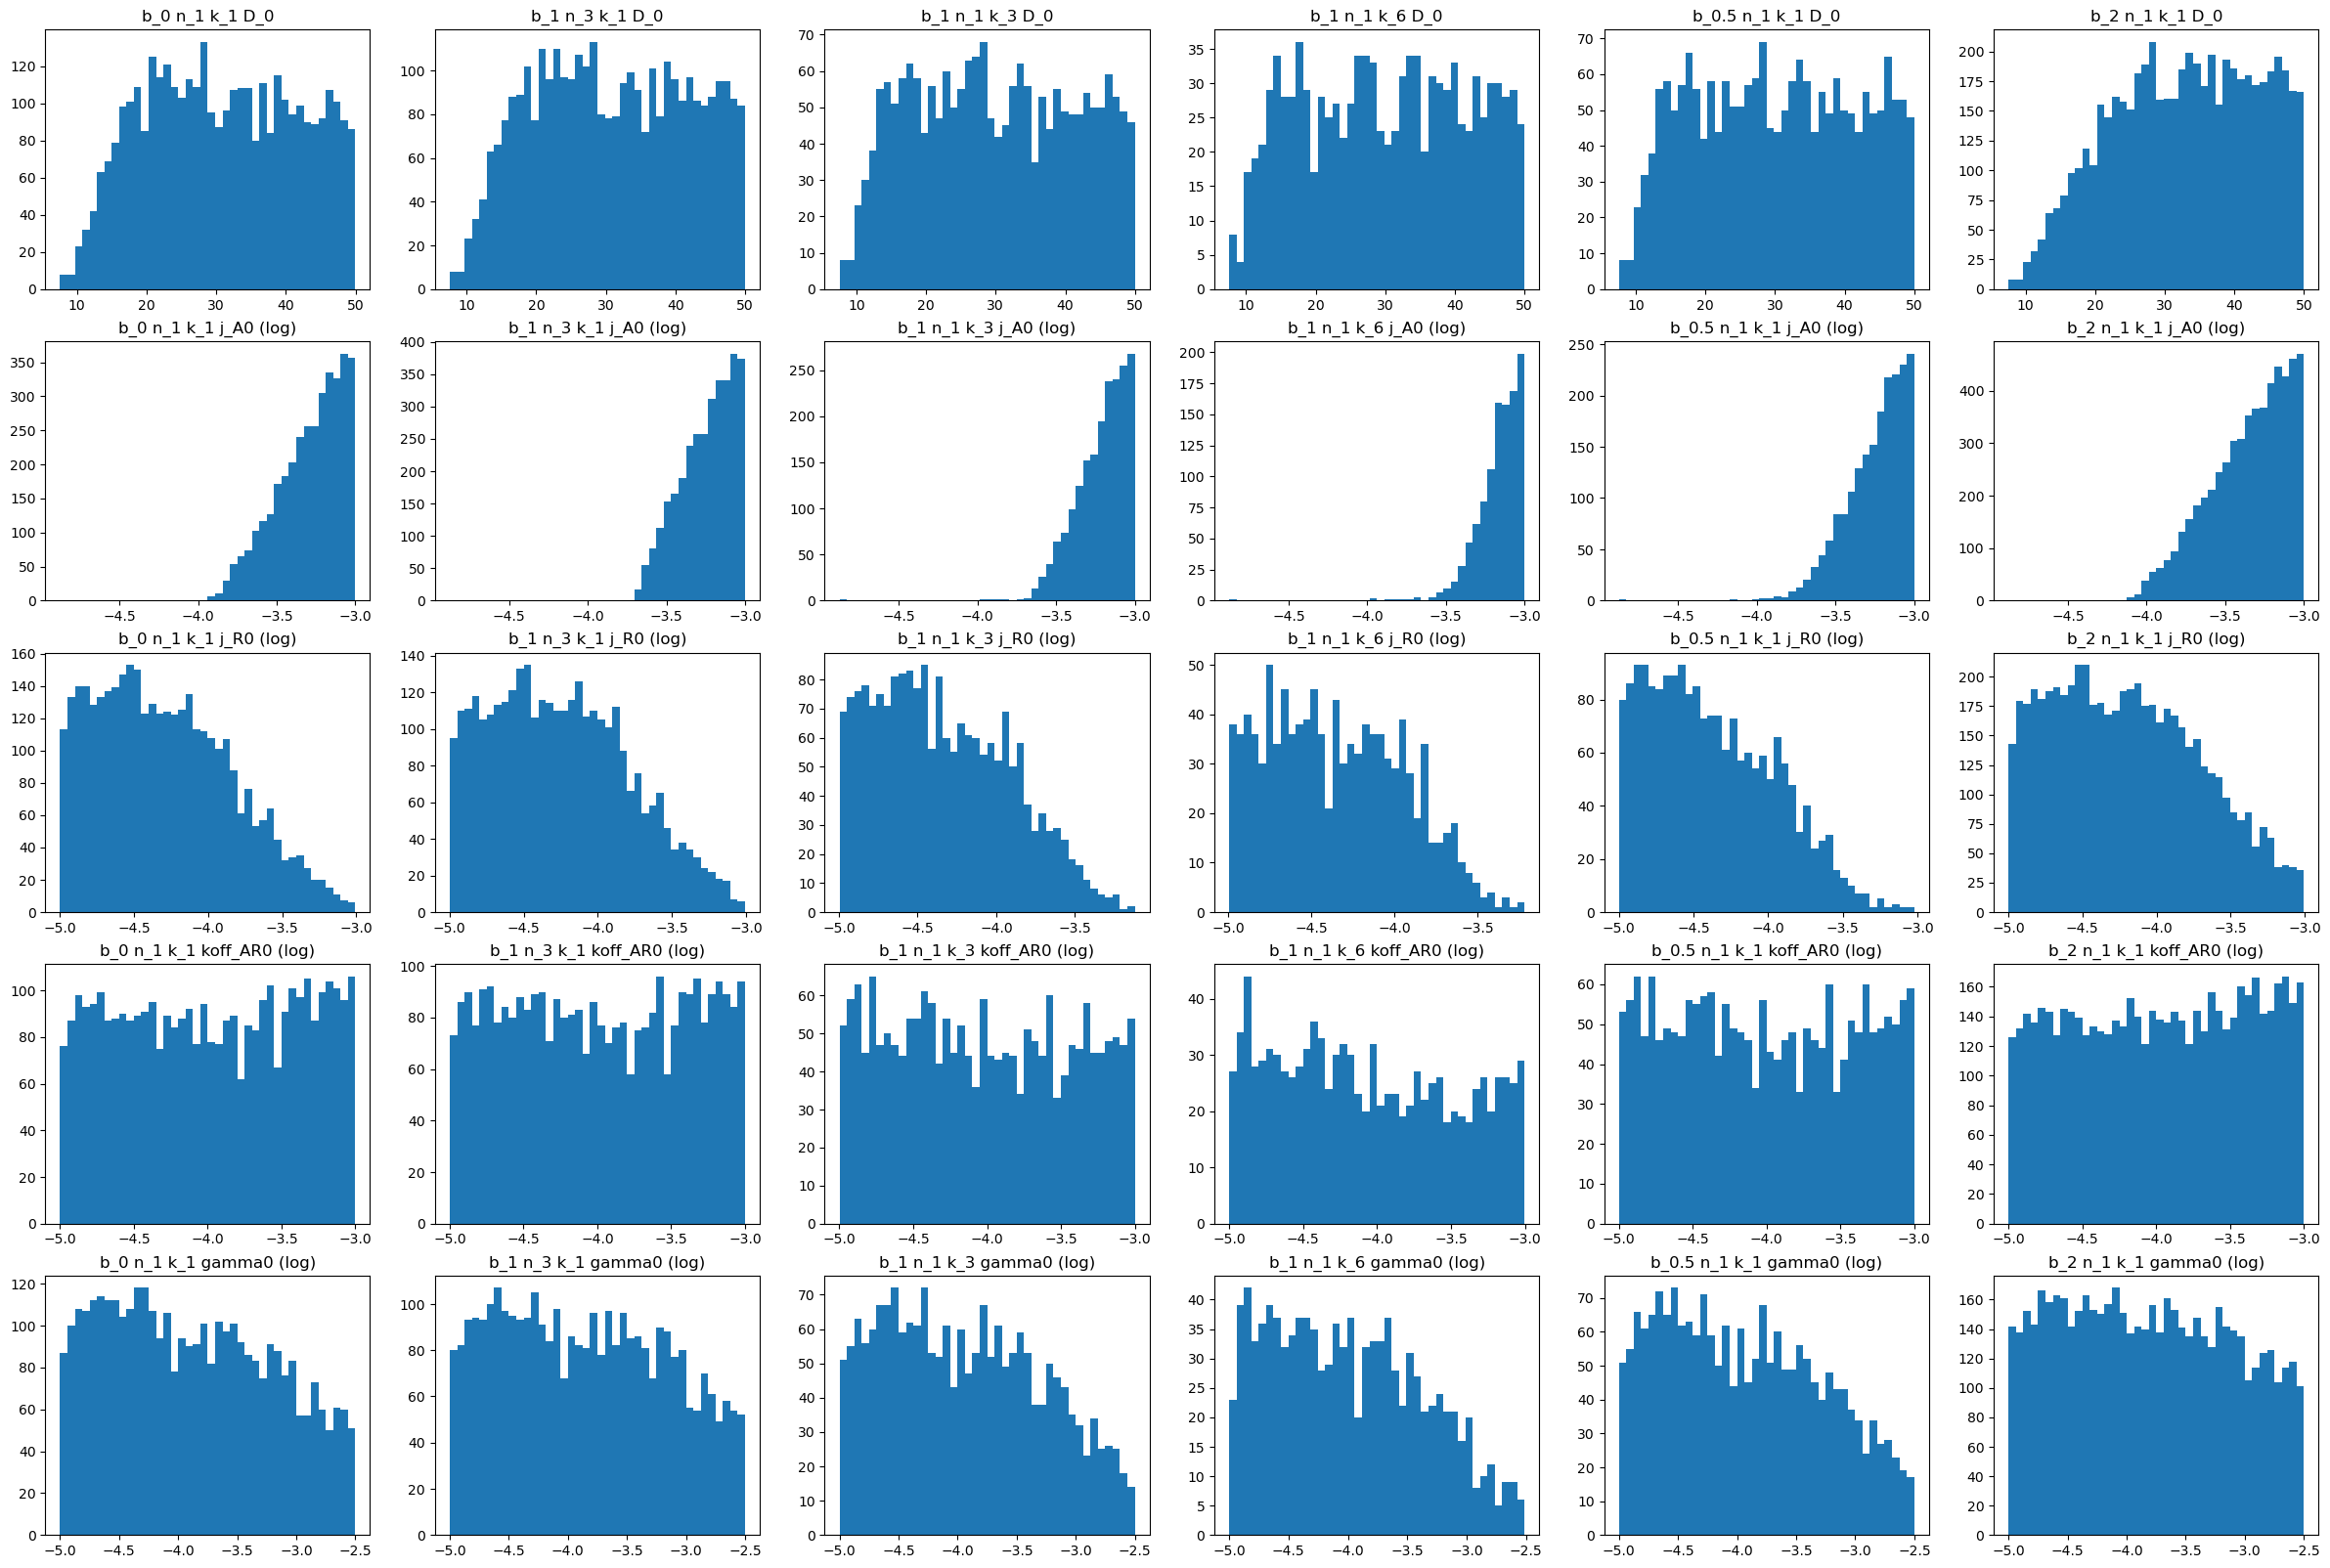

In [29]:
n_bins = 40

fig, axs = plt.subplots(5, 6, figsize=(30, 20))

b0 = beta_dict[betas[0]]
for i, b1 in enumerate(betas[1:]):
    worsened_indices = np.bitwise_and(
        sankey_raw[0] == "2 inside_hull",
        sankey_raw[i + 1] == "3 not_proofreading_or_active"
    )
    for j, (parameter, p_min, p_max) in enumerate(
        [
            ("D_0", 0, 50),
            ("j_A0 (log)", -5, -3),
            ("j_R0 (log)", -5, -3),
            ("koff_AR0 (log)", -5, -3),
            ("gamma0 (log)", -5, -2.5),
            # ("koff_AR0 + gamma0 (log)", np.log10(2e-5), np.log10(1e-3 + 10**-2.5)),
        ]
    ):
        bin_define = np.arange(p_min, p_max, (p_max - p_min) / n_bins)
        axs[j, i].hist(simulations.get_parameters_log()[worsened_indices, j], bins=n_bins)
        axs[j, i].title.set_text(beta_dict[b1] + " " + parameter)

plt.show()

    